# Первая часть

ROC-AUC: 0.79


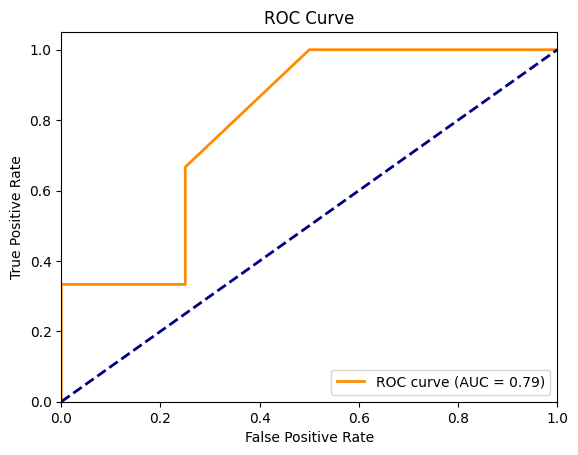

In [ ]:
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt

# Ваши данные
scores = [0.5, 0.1, 0.2, 0.6, 0.2, 0.3, 0.0]
labels = [0, 0, 0, 1, 1, 1, 0]

# Вычислить ROC-кривую и площадь под ней (AUC)
fpr, tpr, thresholds = roc_curve(labels, scores)
roc_auc = auc(fpr, tpr)

# Вывести ROC-AUC
print(f'ROC-AUC: {roc_auc:.2f}')

# Построить ROC-кривую
plt.figure()
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (AUC = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve')
plt.legend(loc="lower right")
plt.show()


## Предварительный анализ данных
Первым этапом проводится предварительная обработка данных из файлов с двумя наборами данных orders.csv и visutors.csv.

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import math as mth
from scipy import stats

In [ ]:
url = "/content/drive/MyDrive/orders.csv"
df_orders = pd.read_csv(url,encoding = "utf-8",sep=",")
df_orders.head(5)

,transactionId,visitorId,date,revenue,group
0,3667963787,3312258926,2019-08-15,1650,B
1,2804400009,3642806036,2019-08-15,730,B
2,2961555356,4069496402,2019-08-15,400,A
3,3797467345,1196621759,2019-08-15,9759,B
4,2282983706,2322279887,2019-08-15,2308,B


Данный набор содержит номер транзакций, ID устройств, которые являются инициаторами этих транзакций, доход с транзакций и группы, к которым относятся клиенты.

In [ ]:
url = "/content/drive/MyDrive/visitors.csv"
df_visitors = pd.read_csv(url,encoding = "utf-8",sep=",")
df_visitors.head(5)

,date,group,visitors
0,2019-08-01,A,719
1,2019-08-02,A,619
2,2019-08-03,A,507
3,2019-08-04,A,717
4,2019-08-05,A,756


Набор данных содержит три столбца: Дата измерений, группа, к которой относятся пользователи и количество посетителей.

Затем выводится информация об этих наборах данных.

In [ ]:
df_orders.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1197 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1197 non-null   int64 
 1   visitorId      1197 non-null   int64 
 2   date           1197 non-null   object
 3   revenue        1197 non-null   int64 
 4   group          1197 non-null   object
dtypes: int64(3), object(2)
memory usage: 46.9+ KB


In [ ]:
df_visitors.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 62 entries, 0 to 61
Data columns (total 3 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   date      62 non-null     object
 1   group     62 non-null     object
 2   visitors  62 non-null     int64 
dtypes: int64(1), object(2)
memory usage: 1.6+ KB


Из выведенной информации видно, что пропусков в данных нет, следовательно обрабатывать их не надо. В первом наборе данных всего 62 строки с данными, во втором 1197. Все столбцы имеют нужный тип данных, поэтому менять их не придётся.

Набор данных с транзакциями проверяется на наличие дубликатов.

In [ ]:
df_orders.duplicated().sum()

0

Из набора данных с транзакциями удаляются пересекающиеся между группами записи.

In [ ]:
group_duplicates = dict(df_orders[df_orders[["visitorId"]].duplicated()].groupby(by=["visitorId", "group"]).count().sort_values("transactionId").index)
for k in group_duplicates.keys():
    duplicates_idx = df_orders[(df_orders["visitorId"] == k) & (df_orders["group"] != group_duplicates[k])].index
    df_orders = df_orders.drop(index=duplicates_idx)
df_orders.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1124 entries, 0 to 1196
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   transactionId  1124 non-null   int64 
 1   visitorId      1124 non-null   int64 
 2   date           1124 non-null   object
 3   revenue        1124 non-null   int64 
 4   group          1124 non-null   object
dtypes: int64(3), object(2)
memory usage: 52.7+ KB


Так же проверяется наличие дубликатов в наборе данных с количеством поситителей

In [ ]:
df_visitors.duplicated().sum()

0

Затем в обоих наборах данных ищутся скрытые дубликаты в столбцах с группами и датами.

In [ ]:
print(df_orders["group"].unique())
print(df_orders["date"].unique())

['B' 'A']
['2019-08-15' '2019-08-16' '2019-08-01' '2019-08-22' '2019-08-17'
 '2019-08-23' '2019-08-02' '2019-08-18' '2019-08-24' '2019-08-03'
 '2019-08-25' '2019-08-28' '2019-08-19' '2019-08-06' '2019-08-26'
 '2019-08-29' '2019-08-04' '2019-08-20' '2019-08-09' '2019-08-07'
 '2019-08-30' '2019-08-05' '2019-08-27' '2019-08-21' '2019-08-08'
 '2019-08-10' '2019-08-31' '2019-08-11' '2019-08-12' '2019-08-13'
 '2019-08-14']


In [ ]:
print(df_visitors["group"].unique())
print(df_visitors["date"].unique())

['A' 'B']
['2019-08-01' '2019-08-02' '2019-08-03' '2019-08-04' '2019-08-05'
 '2019-08-06' '2019-08-07' '2019-08-08' '2019-08-09' '2019-08-10'
 '2019-08-11' '2019-08-12' '2019-08-13' '2019-08-14' '2019-08-15'
 '2019-08-16' '2019-08-17' '2019-08-18' '2019-08-19' '2019-08-20'
 '2019-08-21' '2019-08-22' '2019-08-23' '2019-08-24' '2019-08-25'
 '2019-08-26' '2019-08-27' '2019-08-28' '2019-08-29' '2019-08-30'
 '2019-08-31']


Из выведенного видно, что скрытых дубликатов нет.

## Основное задание

Создается массив уникальных пар значений дат и групп теста.

In [ ]:
orders_group = df_orders[['date','group']].drop_duplicates()
orders_group.head(5)

,date,group
0,2019-08-15,B
7,2019-08-15,A
45,2019-08-16,A
47,2019-08-16,B
55,2019-08-01,A


Получаем агрегированные кумулятивные данные по дням о
заказах.

In [ ]:
orders_agg = orders_group.apply(lambda x:
df_orders[np.logical_and(df_orders['date'] <= x['date'], df_orders['group']
                         == x['group'])].agg({'date' : 'max', 'group' : 'max',
                                              'transactionId' : 'nunique', 'visitorId' : 'nunique',
                                              'revenue' : 'sum'}),
                              axis=1).sort_values(by=['date','group'])

orders_agg.head(5)

,date,group,transactionId,visitorId,revenue
55,2019-08-01,A,24,20,148579
66,2019-08-01,B,19,18,82717
175,2019-08-02,A,44,38,242401
173,2019-08-02,B,42,40,244760
291,2019-08-03,A,68,62,354874


Получаем агрегированные кумулятивные данные по дням о
посетителях.

In [ ]:
visitor_agg =  orders_group.apply(
    lambda x: df_visitors[np.logical_and(df_visitors['date'] <= x['date'], df_visitors['group']
                                         == x['group'])].agg({'date' : 'max', 'group' : 'max', 'visitors' : 'sum'}),
                                  axis=1).sort_values(by=['date','group'])
visitor_agg.head(5)

,date,group,visitors
55,2019-08-01,A,719
66,2019-08-01,B,713
175,2019-08-02,A,1338
173,2019-08-02,B,1294
291,2019-08-03,A,1845


Объединяем данные в одну таблицу с помощью метода merge.

In [ ]:
cumulativeData = pd.merge(orders_agg, visitor_agg)
cumulativeData.head(5)

,date,group,transactionId,visitorId,revenue,visitors
0,2019-08-01,A,24,20,148579,719
1,2019-08-01,B,19,18,82717,713
2,2019-08-02,A,44,38,242401,1338
3,2019-08-02,B,42,40,244760,1294
4,2019-08-03,A,68,62,354874,1845


Затем согласно варианту строим график выручки по группам А и B, где по оси y
– revenue, по оси x - date.

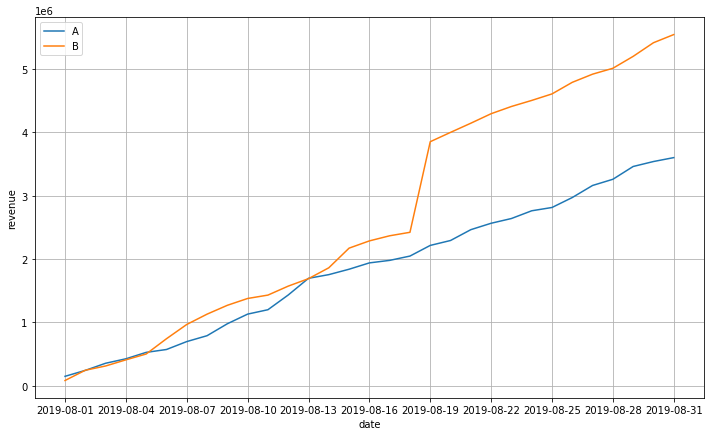

In [ ]:
date_revenue = pd.DataFrame(cumulativeData.groupby(["group", "date"],as_index=False)["revenue"].sum())
plt.figure(figsize=(12, 7))
plt.plot(date_revenue[date_revenue["group"] == "A"]["date"], date_revenue[date_revenue["group"] == "A"]["revenue"], label="A")
plt.plot(date_revenue[date_revenue["group"] == "B"]["date"], date_revenue[date_revenue["group"] == "B"]["revenue"], label="B")
plt.ylabel("revenue")
plt.xlabel("date")
plt.legend()
plt.grid()
plt.xticks(np.arange(0, 31, 3))
plt.show()

# Вторая часть

## Предварительный анализ данных

Вторым этапом проводится предварительная обработка данных из файла logs_exp.csv и проводится A/B-тестирование.

In [ ]:
url = "/content/drive/MyDrive/logs_exp.csv"
df_logs = pd.read_csv(url,encoding = "utf-8",sep="\t")
df_logs.head(5)

,EventName,DeviceIDHash,EventTimestamp,ExpId
0,MainScreenAppear,4575588528974610257,1564029816,246
1,MainScreenAppear,7416695313311560658,1564053102,246
2,PaymentScreenSuccessful,3518123091307005509,1564054127,248
3,CartScreenAppear,3518123091307005509,1564054127,248
4,PaymentScreenSuccessful,6217807653094995999,1564055322,248


Набор данных содержит действия посетителей или события.

Затем выводится информация об этом наборе данных.

In [ ]:
df_logs.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 244126 entries, 0 to 244125
Data columns (total 4 columns):
 #   Column          Non-Null Count   Dtype 
---  ------          --------------   ----- 
 0   EventName       244126 non-null  object
 1   DeviceIDHash    244126 non-null  int64 
 2   EventTimestamp  244126 non-null  int64 
 3   ExpId           244126 non-null  int64 
dtypes: int64(3), object(1)
memory usage: 7.5+ MB


Из выведенной информации видно, что в наборе данных 244126 строк и 4 столбца: 1 - название события, 2 - ID устройства, с которого было выполнено данное событие,3 - время, события и 4 - класс эксперемента,пустых ячеек в наборе нет, следовательно их обрабатывать нет необходимости, все данные в столбцах имеют верный тип данных: Столбец EventName - тип данных object, остальные столбы - тип данных int64.

После этого набор данных проверяется на явные дубликаты.

In [ ]:
df_logs.duplicated().sum()

413

Так как в наборе есть явные дубликаты, они удаляются из набора.

In [ ]:
df_logs = df_logs.drop_duplicates().reset_index()
df_logs.duplicated().sum()

0

Затем проверяется набор на наличие скрытых дубликатов.

In [ ]:
df_logs["EventName"].unique()

array(['MainScreenAppear', 'PaymentScreenSuccessful', 'CartScreenAppear',
       'OffersScreenAppear', 'Tutorial'], dtype=object)

Скрытых дубликатов в наборе нет.

## Основная часть

Подсчитывается количество каждого события и сортируется в порядке убывания.

In [ ]:
df_logs.groupby(["EventName"]).count()[["index"]].rename(columns={"index": "count"}).sort_values("count", ascending=False)

,count
EventName,
MainScreenAppear,119101
OffersScreenAppear,46808
CartScreenAppear,42668
PaymentScreenSuccessful,34118
Tutorial,1018


Из выведенной таблицы видно, что наибольшей популярностью пользуется Главное окно, на которое заходят почти столько же раз сколько суммарно на другие окна. Раздел с туториалом не пользуется популярностью.

Затем подсчитывается количество пользователей, совершивших определенное действие.

In [ ]:
usersByEvent = df_logs.groupby(["EventName", "DeviceIDHash"]).count()[["index"]].rename(columns=
                                                                        {"index": "count"}).groupby(["EventName"]).count().sort_values("count", ascending=False)
usersByEvent

,count
EventName,
MainScreenAppear,7439
OffersScreenAppear,4613
CartScreenAppear,3749
PaymentScreenSuccessful,3547
Tutorial,847


В этом случае популярность между событиями распределена так же.

После подсчитывается количество пользователей в каждой группе.

In [ ]:
df_logs.groupby(["ExpId", "DeviceIDHash"]).count()[["index"]].rename(columns={"index": "count"}).groupby(["ExpId"]).count()

,count
ExpId,
246,2489
247,2520
248,2542


Подсчитываем количество уникальных пользователей.

In [ ]:
len(df_logs['DeviceIDHash'].unique())

7551

Сумма устройств в каждой группе равно общему количеству уникальных устройств,следовательно одного устройства в нескольких группах не может быть. Различия в количестве пользователей, для групп, небольшие, следовательно можно проводить А/А-тест.

А/А-тест - тесты, проводимые перед А/В тестированием, чтобы убедиться, что нынешние показатели не являются выбросами(вероятность получения таких же результатов статистики или выше должна быть больше критического значения).

Нулевая гипотеза: Группы 246 и 247 не имеют различий.

Альтернативная гипотеза: Группы 246 и 247 отличаются.

Сначала считаем статистику в стандартных отклонениях стандартного нормального распределения. Если бы пропорции были равны, разница между ними была бы равна 0. Дальше высчитывается вероятность того, что при следующих измерениях полученные результаты будут либо идентичны нынешним, либо больше, если эта вероятность меньше критического значения, то нулевая гипотеза отвергается, следовательно проводить A/B-тесты бесполезно, так как данные не корректные, если вероятность больше, то можно проводить A/B-тесты.

Создаем функцию для проведения A/A-теста.

In [ ]:
def test_groups(group_a, group_b, event, alpha):
    print("\n",event)
    #получим количество успехов
    group_users = np.array([df_logs.query('EventName == @event and ExpId == @group_a').DeviceIDHash.nunique(),
                            df_logs.query('EventName == @event and ExpId == @group_b').DeviceIDHash.nunique()])
    #получим количество пользователей в группах
    total_users = np.array([df_logs.query('ExpId == @group_a').DeviceIDHash.nunique(),
                            df_logs.query('ExpId == @group_b').DeviceIDHash.nunique()])
    # пропорция успехов в первой группе:
    p1 = group_users[0]/total_users[0]
    # пропорция успехов во второй группе:
    p2 = group_users[1]/total_users[1]
    # пропорция успехов в комбинированном датасете:
    p_combined = (group_users[0] + group_users[1]) / (total_users[0] + total_users[1])
    # разница пропорций в датасетах
    difference = p1 - p2
    # считаем статистику в ст.отклонениях стандартного нормального распределения
    z_value = difference / mth.sqrt(p_combined * (1 - p_combined) * (1 / total_users[0] + 1 / total_users[1]))
    # задаем стандартное нормальное распределение(среднее 0, ст.отклонение 1)
    distr = stats.norm(0, 1)
    p_value = (1 - distr.cdf(abs(z_value))) * 2
    print('p-значение: ', p_value)
    if p_value < alpha:
        print('Отвергаем нулевую гипотезу: есть значимая разница между долями')
    else:
        print( 'Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными')


Проводим A/A-тест для каждого события.

In [ ]:
for en in df_logs["EventName"].unique():
    test_groups(246, 247, en, 0.05)


 MainScreenAppear
p-значение:  0.5856639791209877
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

 PaymentScreenSuccessful
p-значение:  0.10902546202332886
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

 CartScreenAppear
p-значение:  0.19817540651836918
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

 OffersScreenAppear
p-значение:  0.3233225048227193
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными

 Tutorial
p-значение:  0.8756574258016974
Не получилось отвергнуть нулевую гипотезу, нет оснований считать доли разными


Из полученных результатов видно, что нулевая гипотеза не отвергнута ни у одного события, значит можно приступать к A/B-тестированию.

А/B-тест - тест, предназначенный для сравнения двух групп между собой, для выявления эффективности одной перед другой. Для этого вычисляется p-value - вероятность того, что для заданной модели, значения получатся такими же или больше. Если вероятность меньше коэффициента значимости, то нулевую гипотезу отвергают, если больше, то не отвергают

Нулевая гипотеза: Нет разницы между группой 246 и 248

Альтернативная гипотеза: Между группами 246 и 248 есть разница

Создаем функцию для А/B-теста.

In [ ]:
def ab_test(group_a, group_b, events, alpha):
    users_group_a = []
    users_group_b = []
    for en in events:
        group_users = np.array([df_logs.query('EventName == @en and ExpId == @group_a').DeviceIDHash.nunique(),
                                df_logs.query('EventName == @en and ExpId == @group_b').DeviceIDHash.nunique()])
        users_group_a.append(group_users[0])
        users_group_b.append(group_users[1])
    results = stats.ttest_ind(users_group_a, users_group_b)

    print(f"p-значение для данных измерений - {results.pvalue}")

    if results.pvalue < alpha:
        print("Отвергаем нулевую гипотезу")
    else:
        print("Не получилось отвергнуть нулевую гипотезу")

Проводим A/B-тест.

In [ ]:
ab_test(246, 248, df_logs["EventName"].unique(), 0.05)

p-значение для данных измерений - 0.9978294722639669
Не получилось отвергнуть нулевую гипотезу


In [ ]:
ab_test(247, 248, df_logs["EventName"].unique(), 0.05)

p-значение для данных измерений - 0.9855100960132814
Не получилось отвергнуть нулевую гипотезу


Из полученного результата видно, что нулевая гипотеза не отвергается, следовательно разницы между группами 246(экспериментальной) и 248(контрольной) нет.

# Вывод

В результате выполнения работы были повышены навыки работы с библиотекой pandas, в особенности с функциями группировки и агрегирования, освоены принципы работы А/А и А/В-тестов, реализованы данные тесты, повторен необходимый минимум математики для реализации данных тестов, проанализировано три набора данных, два из которых были связаны между собой и на основе связанных наборов данных создана таблица, содержащая важнейшие значения этих наборов, освоены и изучены методы pandas, для агрегирования данных.

Все наборы данных, которые обрабатывались в данной лабораторной работе представлены в удобном для проведения A/A и A/B-тестов виде, следовательно для проведения тестов не было необходимости проводить нестандартную обработку, кроме удаления дубликатов и пересекающихся записей между группами.

В проведенных A/A и A/B-тестах нулевые гипотезы не были отвергнуты, следовательно необходимо изучить данную гипотезу другими средствами анализа, чтобы подтвердить её.

# Дополнительное задание

Нужно подсчитать процент пользователей, которые не переходили с одного экрана на другой. Для этого находится разность между количеством пользователей, побывавших на каждом экране, и находится процент этой разности от предыдущего экрана.

In [ ]:
usersByEvent = usersByEvent.drop(index="Tutorial")

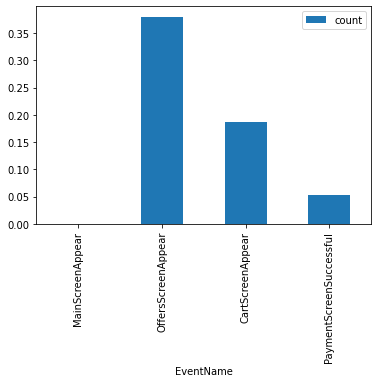

In [ ]:
usersByEvent.pct_change().mul(-1).plot.bar()

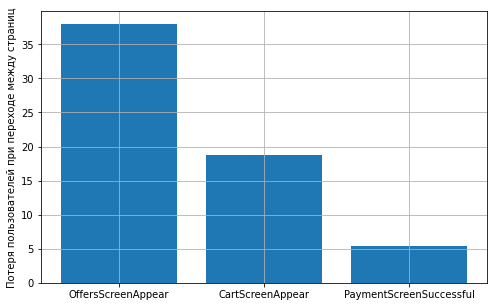

In [ ]:
idx = list(usersByEvent.index)
val = usersByEvent.values
data = []
for i in range(3):
    data.append(float((val[i]-val[i+1])/val[i]*100))
plt.figure(figsize=(8, 5))
plt.bar(idx[1:4], data)
plt.ylabel("Потеря пользователей при переходе между страниц")
plt.grid()
plt.show()

Из полученных данных видно, что с главного экрана на экран с дополнительной информацией о товаре не переходит больше 35% пользователей, что говорит о возможных недостатках на главной странице. При переходе с экрана с дополнительной информацией на экран с корзиной немного меньше, чем 20%, что так же свидетельствует о возможном наличии недостатков, значительно сокращающих количество покупателей. Переход с экрана корзины на экран оплаты теряет чуть больше 5% пользователей, что не указывает на наличие серьезных недастатков.